[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DSSHN_lRd0A_tPBwYBi6zlOd_9N1DBJ3#scrollTo=dpz7yKFTYXPZ)

## HW Requirement

• Rewrite the code of weight-tuning_EB to make the code of 
regularizing_EB.\
• Rewrite the code of weight-tuning_LG_UA to make the 
code of regularizing_LG_UA.\
• Rewrite the code of weight-tuning_EB_LG_UA to make the 
code of regularizing_EB_LG_UA.\
• Rewrite the code of weight-tuning_EB to make the code of 
regularizing_DO.\
• Rewrite the code of weight-tuning_EB to make the code of 
regularizing_BN.

## Model

In [30]:
import torch
from torch import nn, optim, Generator
from torch.utils.data import DataLoader, Dataset, random_split
from typing import Iterable, Callable, Type, Optional, Union, Tuple, List


In [31]:
from operator import mul

def product(nums: Iterable[Type], func: Callable[[Type, Type], Type] = mul):
    def _product(nums):
        nonlocal func
        if len(nums) == 1:
            return nums[0]
        return func(nums[-1], _product(nums[:-1]))
    try:
        return _product(nums)
    except Exception as e:
        raise e

In [32]:
from collections import deque


class TwoLayerNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, init_method: Callable, active_func: Callable[[], nn.modules.module.Module],
                 DO: float, if_BN: bool, store_size: int = 1):
        super(TwoLayerNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # dropout
        self.do = nn.Dropout(DO)
        # first layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # batch norm
        self.bn1 = nn.BatchNorm1d(hidden_size) if if_BN else None
        # activation
        self.active_func = active_func()
        # second layer
        self.fc2 = nn.Linear(hidden_size, num_classes)
        # initialize
        for param in self.parameters():
            init_method(param)
        self.storage = deque(maxlen=store_size)

    def forward(self, x) -> torch.Tensor:
        out = self.do(x)
        out = self.fc1(out)
        if self.bn1:
            out = self.bn1(out)
        out = self.active_func(out)
        out = self.fc2(out)
        return out


In [33]:
class Regularization(nn.Module):
    def __init__(self):
        super(Regularization, self).__init__()


class L2_Regularization(Regularization):
    def __init__(self, weight_decay: float):
        super(L2_Regularization, self).__init__()
        if weight_decay <= 0:
            raise ValueError("param weight_decay can not <=0!!")
        self.weight_decay = weight_decay

    def forward(self, model: nn.Module) -> Union[torch.Tensor, float]:
        reg = 0
        for name, parameter in model.named_parameters():
            if "weight" in name:
                reg += torch.sum(parameter**2)
        return self.weight_decay * reg


In [34]:
def validate(model: nn.Module, device: str, valloader: DataLoader[Dataset[torch.Tensor]], criterion: nn.modules.loss._Loss) \
        -> Tuple[float, float]:
    # Validate the model
    model.to(device)
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for X, y in valloader:
            X = X.view(-1, model.input_size).to(device)
            y = y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == y).sum().item()
        val_loss /= len(valloader.dataset)
        val_accuracy = val_correct / len(valloader.dataset)
    return val_loss, val_accuracy


In [35]:
def train(model: TwoLayerNetwork, opt: Callable[..., optim.Optimizer], device: str, epochs: Union[int, float], learning_rate: float, trainloader: DataLoader[Dataset[torch.Tensor]], valloader: DataLoader[Dataset[torch.Tensor]], criterion: nn.modules.loss._Loss,
          sched: Optional[Callable[[optim.Optimizer], optim.lr_scheduler._LRScheduler]], regularization: Optional[Regularization], learning_goal: float, min_lr: float, if_lr_adjust: bool) -> List[Tuple[float, float, float, float]]:
    def forward_backward(optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss, regularization: Optional[Regularization], model: TwoLayerNetwork, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        optimizer.zero_grad()
        outputs = model(X)
        loss_all = criterion(
            outputs, y) + regularization(model) if regularization else criterion(outputs, y)
        loss_all.backward()
        optimizer.step()
        return loss_all, outputs

    if epochs < 1:
        raise ValueError("Invalid epoch!!")
    model.to(device)
    init_lr = learning_rate
    # if not model.storage[-1]
    model.storage.append(list(model.parameters()))
    optimizer = opt(model.storage[-1], lr=learning_rate)
    scheduler = sched(optimizer) if sched else None
    history = []
    pre_loss = float("inf")
    # Train the model
    epoch = 0
    while epoch < epochs:
        # Train the model
        train_loss = 0.0
        train_correct = 0
        model.train()
        for X, y in trainloader:
            X = X.view(-1, model.input_size).to(device)
            y = y.to(device)
            loss_all, outputs = forward_backward(
                optimizer, criterion, regularization, model, y)
            if if_lr_adjust:
                while pre_loss <= loss_all.item():
                    if learning_rate < min_lr:
                        # return history
                        learning_rate = init_lr
                        optimizer = opt(model.storage[-1], lr=learning_rate)
                        loss_all, outputs = forward_backward(
                            optimizer, criterion, regularization, model, y)
                        # raise ValueError(f"{learning_rate} < {min_lr}")
                        break
                    learning_rate *= 0.7
                    optimizer = opt(model.storage[-1], lr=learning_rate)
                    loss_all, outputs = forward_backward(
                        optimizer, criterion, regularization, model, y)
                learning_rate *= 1.2
            train_loss += loss_all.item() * X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == y).sum().item()
            pre_loss = loss_all.item()
            model.storage.append(list(model.parameters()))
        train_loss /= len(trainloader.dataset)
        train_accuracy = train_correct / len(trainloader.dataset)
        # Validate the model
        val_loss, val_accuracy = validate(
            model=model, device=device, valloader=valloader, criterion=criterion)
        # Log Statics
        history.append((train_loss, train_accuracy, val_loss, val_accuracy))
        # Stopping criteria
        if learning_goal < val_accuracy:
            return history
        # Update loop
        if scheduler:
            scheduler.step()
        epoch += 1
    return history


In [36]:
def test(model: nn.Module, device: str, testloader: DataLoader[Dataset]) -> float:
    return validate(model=model, device=device, valloader=testloader, criterion=nn.CrossEntropyLoss())[1]


# Dataset

### pytorch dataset

In [37]:
# load pytorch dataset
from torchvision import datasets, transforms


def getPytorchData(train: float = 0.8, remain: float = 0.1) \
    -> tuple[DataLoader[Dataset[torch.Tensor]], DataLoader[Dataset[torch.Tensor]], DataLoader[Dataset[torch.Tensor]], int, int]:
    """
    Args:
        train: train_amount / total_amount or 1 - valid_amount / total_amount
        remain: reduce data amount to save time
    """
    # preprocess: flatten, normalize, drop 90%, split
    transform = transforms.transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    if 0 >= train or train >= 1:
        raise ValueError()
    if 0 > remain or remain > 1:
        raise ValueError()
    # Split the training set into training and validation sets
    trainset = datasets.FashionMNIST(
        root="./data/", train=True, download=False, transform=transform)
    train_count = int(train * remain * len(trainset))
    valid_count = int((1 - train) * remain * len(trainset))
    if train_count * valid_count == 0:
        raise ValueError()
    datum_size = product(trainset[0][0].size())
    class_amount = len(trainset.classes)
    testset = datasets.FashionMNIST(
        root="./data/", train=False, download=False, transform=transform)
    print(train_count, valid_count, len(testset))
    trainset, valset, _ = random_split(
        trainset, (train_count, valid_count, len(trainset) - train_count - valid_count), Generator().manual_seed(42))
    # Create dataloaders to load the data in batches
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    valloader = DataLoader(valset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=32, shuffle=True)
    return trainloader, valloader, testloader, datum_size, class_amount


# Training

### setting

In [38]:
device = "cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu"
trainloader, valloader, testloader, input_size, output_size = getPytorchData()
learning_rate = 0.001
weight_decay = 0.001
criterion = nn.CrossEntropyLoss()
lg = 0.82

4800 1199 10000


### r_EB

In [39]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.0, False)
optimize = optim.SGD
schedule = None
learning_goal = 1. #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
r_EB_baseline = test(model, device, testloader)
r_EB_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True)
r_EB_result = test(model, device, testloader)
print(r_EB_baseline, r_EB_history, r_EB_result, sep="\n")


0.0558
[(2.1573723181088766, 0.24666666666666667, 1.9519512021014649, 0.32360300250208507), (1.8472191254297892, 0.381875, 1.7127417697819, 0.3878231859883236), (1.5489835460980734, 0.45895833333333336, 1.3356857110899225, 0.5271059216013344), (1.240628335873286, 0.5983333333333334, 1.087144137820768, 0.6663886572143453), (1.0468701306978863, 0.680625, 0.9404577001916855, 0.6922435362802335), (0.9354435169696808, 0.7066666666666667, 0.8486955628681422, 0.7030859049207673), (0.8661119508743286, 0.72625, 0.796444343715235, 0.731442869057548), (0.8228448339303335, 0.7322916666666667, 0.7589296126882666, 0.7389491242702252), (0.7895270796616872, 0.7347916666666666, 0.7295488313996265, 0.7489574645537949), (0.7613249572118124, 0.748125, 0.7085887626422456, 0.7614678899082569), (0.7390570930639903, 0.75375, 0.6928269263602377, 0.7631359466221852), (0.7216430441538493, 0.759375, 0.6779380303009835, 0.7572977481234362), (0.7040499397118887, 0.7645833333333333, 0.6632574388541411, 0.77981651376

In [40]:
with open("./data/r_eb.txt", "w") as f:
    f.write(f"baseline: {r_EB_baseline}\n")
    for epoch in range(len(r_EB_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_EB_history[epoch][0], r_EB_history[epoch][1], r_EB_history[epoch][2], r_EB_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_EB_result}\n")


### r_LG_UA

In [41]:
hidden_size = 11
epochs = float("inf")
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.0, False)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
r_LG_UA_baseline = test(model, device, testloader)
r_LG_UA_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True)
r_LG_UA_result = test(model, device, testloader)
print(r_LG_UA_baseline, r_LG_UA_history, r_LG_UA_result, sep="\n")


0.0654
[(2.1176943310101826, 0.23354166666666668, 1.8487555923016494, 0.32777314428690574), (1.683793965180715, 0.4454166666666667, 1.4838327652618624, 0.5337781484570475), (1.3727852217356364, 0.5870833333333333, 1.2063389025299225, 0.628023352793995), (1.1470066638787588, 0.6570833333333334, 1.0211774393158022, 0.6755629691409508), (1.005992848475774, 0.6870833333333334, 0.9204768883476067, 0.69557964970809), (0.9210611971219381, 0.711875, 0.8541163357224835, 0.713094245204337), (0.8632434006532034, 0.72875, 0.7992485451439801, 0.7297748123436196), (0.8175585683186849, 0.7397916666666666, 0.7709814067479468, 0.7322768974145121), (0.7846631292502085, 0.7483333333333333, 0.7302250149252019, 0.7597998331943286), (0.7559437574942907, 0.75875, 0.7071396113933376, 0.7581317764804003), (0.7335696770747503, 0.76625, 0.6971250292258625, 0.7673060884070059), (0.7138928935925166, 0.7635416666666667, 0.6795318334474476, 0.7614678899082569), (0.6977133868137996, 0.76625, 0.6558201003313263, 0.786

In [42]:
with open("./data/r_lg_ua.txt", "w") as f:
    f.write(f"baseline: {r_LG_UA_baseline}\n")
    for epoch in range(len(r_LG_UA_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_LG_UA_history[epoch][0], r_LG_UA_history[epoch][1], r_LG_UA_history[epoch][2], r_LG_UA_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_LG_UA_result}\n")


### r_EB_LG_UA

In [43]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.0, False)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
r_EB_LG_UA_baseline = test(model, device, testloader)
r_EB_LG_UA_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True)
r_EB_LG_UA_result = test(model, device, testloader)
print(r_EB_LG_UA_baseline, r_EB_LG_UA_history, r_EB_LG_UA_result, sep="\n")


0.0739
[(2.0094326718648277, 0.3460416666666667, 1.674098352574626, 0.46371976647206004), (1.5451402552922566, 0.539375, 1.3521310932145107, 0.5771476230191827), (1.2763099400202433, 0.6041666666666666, 1.1201578319023011, 0.6355296080066722), (1.0891636788845063, 0.651875, 0.9686376174556105, 0.6980817347789825), (0.9692917676766714, 0.6954166666666667, 0.8804507624416972, 0.7055879899916597), (0.893257782459259, 0.7120833333333333, 0.8143619070259902, 0.7289407839866555), (0.8398130885759989, 0.7310416666666667, 0.7724681460330445, 0.7447873227689742), (0.7994534681240718, 0.7445833333333334, 0.736541901110012, 0.749791492910759), (0.765980942050616, 0.756875, 0.7116722265713606, 0.7564637197664721), (0.7429141189654668, 0.7647916666666666, 0.6868662208790974, 0.7664720600500416), (0.7185256977876028, 0.7691666666666667, 0.6669738904151249, 0.7748123436196831), (0.6978589560588201, 0.77625, 0.6480171867367424, 0.7748123436196831), (0.6812894219160079, 0.78375, 0.6362968662363773, 0.7

In [44]:
with open("./data/r_eb_lg_ua.txt", "w") as f:
    f.write(f"baseline: {r_EB_LG_UA_baseline}\n")
    for epoch in range(len(r_EB_LG_UA_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_EB_LG_UA_history[epoch][0], r_EB_LG_UA_history[epoch][1], r_EB_LG_UA_history[epoch][2], r_EB_LG_UA_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_EB_LG_UA_result}\n")


### r_BN

In [45]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.0, True)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = None
r_BN_baseline = test(model, device, testloader)
r_BN_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, False)
r_BN_result = test(model, device, testloader)
print(r_BN_baseline, r_BN_history, r_BN_result, sep="\n")


0.1261
[(2.236937847137451, 0.19791666666666666, 1.9408264336136603, 0.311092577147623), (1.8794985818862915, 0.35604166666666665, 1.7654805476711233, 0.4245204336947456), (1.7632174547513326, 0.4377083333333333, 1.681105643038555, 0.4954128440366973), (1.69356658299764, 0.47708333333333336, 1.6047282560951417, 0.5396163469557965), (1.638869977792104, 0.5191666666666667, 1.5590832272204287, 0.5738115095913261), (1.5871480202674866, 0.5489583333333333, 1.5204932143829384, 0.5954962468723937), (1.5446943879127502, 0.5691666666666667, 1.4710731820527267, 0.6121768140116765), (1.5053355479240418, 0.5895833333333333, 1.4381065971161346, 0.6196830692243537), (1.474905984401703, 0.5970833333333333, 1.4013806936440616, 0.6338615512927439), (1.4365958428382875, 0.6125, 1.3708953868358507, 0.6430358632193495), (1.4067112191518147, 0.6227083333333333, 1.3393544545265115, 0.6563803169307757), (1.3768340357144673, 0.6316666666666667, 1.3123652285789826, 0.6630525437864887), (1.3439476132392882, 0.6

In [46]:
with open("./data/r_bn.txt", "w") as f:
    f.write(f"baseline: {r_BN_baseline}\n")
    for epoch in range(len(r_BN_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_BN_history[epoch][0], r_BN_history[epoch][1], r_BN_history[epoch][2], r_BN_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_BN_result}\n")


### r_DO

In [47]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.2, False)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = None
r_DO_baseline = test(model, device, testloader)
r_DO_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, False)
r_DO_result = test(model, device, testloader)
print(r_DO_baseline, r_DO_history, r_DO_result, sep="\n")


0.1022
[(2.33664510567983, 0.16958333333333334, 2.0601338113318692, 0.3010842368640534), (2.028259805838267, 0.2764583333333333, 1.8609353628031307, 0.377814845704754), (1.8702260700861613, 0.339375, 1.7295151809735334, 0.41618015012510423), (1.7449024812380474, 0.384375, 1.6156072605640517, 0.43286071726438696), (1.6340599862734477, 0.4320833333333333, 1.5054430725974177, 0.47956630525437866), (1.5411364944775898, 0.45229166666666665, 1.390475793417739, 0.5321100917431193), (1.432651235262553, 0.49354166666666666, 1.2876352868147747, 0.5688073394495413), (1.341875918706258, 0.53375, 1.2075119489824107, 0.5954962468723937), (1.262666305700938, 0.5620833333333334, 1.1358496704332226, 0.6321934945788157), (1.2022733243306478, 0.5866666666666667, 1.0767437547718712, 0.6547122602168474), (1.1486763660113017, 0.6066666666666667, 1.0279830795113896, 0.6613844870725605), (1.0967848499615986, 0.6275, 0.9859418078598328, 0.6722268557130943), (1.0584698049227397, 0.634375, 0.9503244884417791, 0.

In [48]:
with open("./data/r_do.txt", "w") as f:
    f.write(f"baseline: {r_DO_baseline}\n")
    for epoch in range(len(r_DO_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_DO_history[epoch][0], r_DO_history[epoch][1], r_DO_history[epoch][2], r_DO_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_DO_result}\n")


### comparison

In [1]:
from matplotlib import pyplot as plt
import re


In [2]:
with open("./data/r_eb.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_EB_history = [[float(e) for e in re.sub(r"[a-z:,_]", " ", l).split()]
                  for l in lines]
print(r_EB_history)

[[2.1573723181088766, 0.24666666666666667, 1.9519512021014649, 0.32360300250208507], [1.8472191254297892, 0.381875, 1.7127417697819, 0.3878231859883236], [1.5489835460980734, 0.45895833333333336, 1.3356857110899225, 0.5271059216013344], [1.240628335873286, 0.5983333333333334, 1.087144137820768, 0.6663886572143453], [1.0468701306978863, 0.680625, 0.9404577001916855, 0.6922435362802335], [0.9354435169696808, 0.7066666666666667, 0.8486955628681422, 0.7030859049207673], [0.8661119508743286, 0.72625, 0.796444343715235, 0.731442869057548], [0.8228448339303335, 0.7322916666666667, 0.7589296126882666, 0.7389491242702252], [0.7895270796616872, 0.7347916666666666, 0.7295488313996265, 0.7489574645537949], [0.7613249572118124, 0.748125, 0.7085887626422456, 0.7614678899082569], [0.7390570930639903, 0.75375, 0.6928269263602377, 0.7631359466221852], [0.7216430441538493, 0.759375, 0.6779380303009835, 0.7572977481234362], [0.7040499397118887, 0.7645833333333333, 0.6632574388541411, 0.7798165137614679],

In [3]:
with open("./data/r_lg_ua.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_LG_UA_history = [[float(e) for e in re.sub(
        r"[a-z:,_]", " ", l).split()] for l in lines]
print(r_LG_UA_history)


[[2.1176943310101826, 0.23354166666666668, 1.8487555923016494, 0.32777314428690574], [1.683793965180715, 0.4454166666666667, 1.4838327652618624, 0.5337781484570475], [1.3727852217356364, 0.5870833333333333, 1.2063389025299225, 0.628023352793995], [1.1470066638787588, 0.6570833333333334, 1.0211774393158022, 0.6755629691409508], [1.005992848475774, 0.6870833333333334, 0.9204768883476067, 0.69557964970809], [0.9210611971219381, 0.711875, 0.8541163357224835, 0.713094245204337], [0.8632434006532034, 0.72875, 0.7992485451439801, 0.7297748123436196], [0.8175585683186849, 0.7397916666666666, 0.7709814067479468, 0.7322768974145121], [0.7846631292502085, 0.7483333333333333, 0.7302250149252019, 0.7597998331943286], [0.7559437574942907, 0.75875, 0.7071396113933376, 0.7581317764804003], [0.7335696770747503, 0.76625, 0.6971250292258625, 0.7673060884070059], [0.7138928935925166, 0.7635416666666667, 0.6795318334474476, 0.7614678899082569], [0.6977133868137996, 0.76625, 0.6558201003313263, 0.7864887406

In [4]:
with open("./data/r_eb_lg_ua.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_EB_LG_UA_history = [[float(e) for e in re.sub(
        r"[a-z:,_]", " ", l).split()] for l in lines]
print(r_EB_LG_UA_history)


[[2.0094326718648277, 0.3460416666666667, 1.674098352574626, 0.46371976647206004], [1.5451402552922566, 0.539375, 1.3521310932145107, 0.5771476230191827], [1.2763099400202433, 0.6041666666666666, 1.1201578319023011, 0.6355296080066722], [1.0891636788845063, 0.651875, 0.9686376174556105, 0.6980817347789825], [0.9692917676766714, 0.6954166666666667, 0.8804507624416972, 0.7055879899916597], [0.893257782459259, 0.7120833333333333, 0.8143619070259902, 0.7289407839866555], [0.8398130885759989, 0.7310416666666667, 0.7724681460330445, 0.7447873227689742], [0.7994534681240718, 0.7445833333333334, 0.736541901110012, 0.749791492910759], [0.765980942050616, 0.756875, 0.7116722265713606, 0.7564637197664721], [0.7429141189654668, 0.7647916666666666, 0.6868662208790974, 0.7664720600500416], [0.7185256977876028, 0.7691666666666667, 0.6669738904151249, 0.7748123436196831], [0.6978589560588201, 0.77625, 0.6480171867367424, 0.7748123436196831], [0.6812894219160079, 0.78375, 0.6362968662363773, 0.78648874

In [5]:
with open("./data/r_do.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_DO_history = [[float(e) for e in re.sub(r"[a-z:,_]", " ", l).split()]
                  for l in lines]
print(r_DO_history)

[[2.33664510567983, 0.16958333333333334, 2.0601338113318692, 0.3010842368640534], [2.028259805838267, 0.2764583333333333, 1.8609353628031307, 0.377814845704754], [1.8702260700861613, 0.339375, 1.7295151809735334, 0.41618015012510423], [1.7449024812380474, 0.384375, 1.6156072605640517, 0.43286071726438696], [1.6340599862734477, 0.4320833333333333, 1.5054430725974177, 0.47956630525437866], [1.5411364944775898, 0.45229166666666665, 1.390475793417739, 0.5321100917431193], [1.432651235262553, 0.49354166666666666, 1.2876352868147747, 0.5688073394495413], [1.341875918706258, 0.53375, 1.2075119489824107, 0.5954962468723937], [1.262666305700938, 0.5620833333333334, 1.1358496704332226, 0.6321934945788157], [1.2022733243306478, 0.5866666666666667, 1.0767437547718712, 0.6547122602168474], [1.1486763660113017, 0.6066666666666667, 1.0279830795113896, 0.6613844870725605], [1.0967848499615986, 0.6275, 0.9859418078598328, 0.6722268557130943], [1.0584698049227397, 0.634375, 0.9503244884417791, 0.6864053

In [6]:
with open("./data/r_bn.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_BN_history = [[float(e) for e in re.sub(r"[a-z:,_]", " ", l).split()]
                  for l in lines]
print(r_BN_history)

[[2.236937847137451, 0.19791666666666666, 1.9408264336136603, 0.311092577147623], [1.8794985818862915, 0.35604166666666665, 1.7654805476711233, 0.4245204336947456], [1.7632174547513326, 0.4377083333333333, 1.681105643038555, 0.4954128440366973], [1.69356658299764, 0.47708333333333336, 1.6047282560951417, 0.5396163469557965], [1.638869977792104, 0.5191666666666667, 1.5590832272204287, 0.5738115095913261], [1.5871480202674866, 0.5489583333333333, 1.5204932143829384, 0.5954962468723937], [1.5446943879127502, 0.5691666666666667, 1.4710731820527267, 0.6121768140116765], [1.5053355479240418, 0.5895833333333333, 1.4381065971161346, 0.6196830692243537], [1.474905984401703, 0.5970833333333333, 1.4013806936440616, 0.6338615512927439], [1.4365958428382875, 0.6125, 1.3708953868358507, 0.6430358632193495], [1.4067112191518147, 0.6227083333333333, 1.3393544545265115, 0.6563803169307757], [1.3768340357144673, 0.6316666666666667, 1.3123652285789826, 0.6630525437864887], [1.3439476132392882, 0.65041666

In [7]:
x = range(len(r_EB_history))
x1 = range(len(r_LG_UA_history))
x2 = range(len(r_EB_LG_UA_history))
x3 = range(len(r_BN_history))
x4 = range(len(r_DO_history))

In [8]:
lg = 0.82


### loss

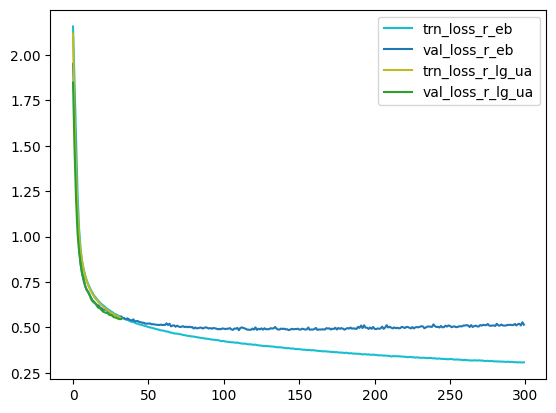

In [9]:
plt.plot(x, [e[0] for e in r_EB_history], "tab:cyan", label="trn_loss_r_eb")
plt.plot(x, [e[2] for e in r_EB_history], "tab:blue", label="val_loss_r_eb")
plt.plot(x1, [e[0] for e in r_LG_UA_history], "tab:olive", label="trn_loss_r_lg_ua")
plt.plot(x1, [e[2] for e in r_LG_UA_history], "tab:green", label="val_loss_r_lg_ua")
# plt.plot(x2, [e[0] for e in r_EB_LG_UA_history], "tab:orange", label="trn_loss_r_eb_lg_ua")
# plt.plot(x2, [e[2] for e in r_EB_LG_UA_history], "tab:red", label="val_loss_r_eb_lg_ua")
plt.legend(loc="upper right")
plt.show()


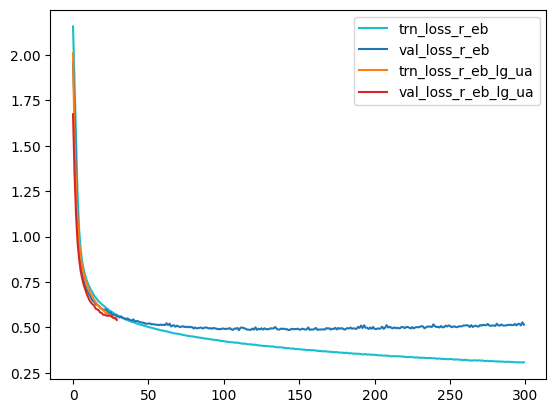

In [10]:
plt.plot(x, [e[0] for e in r_EB_history], "tab:cyan", label="trn_loss_r_eb")
plt.plot(x, [e[2] for e in r_EB_history], "tab:blue", label="val_loss_r_eb")
plt.plot(x2, [e[0] for e in r_EB_LG_UA_history], "tab:orange", label="trn_loss_r_eb_lg_ua")
plt.plot(x2, [e[2] for e in r_EB_LG_UA_history], "tab:red", label="val_loss_r_eb_lg_ua")
plt.legend(loc="upper right")
plt.show()


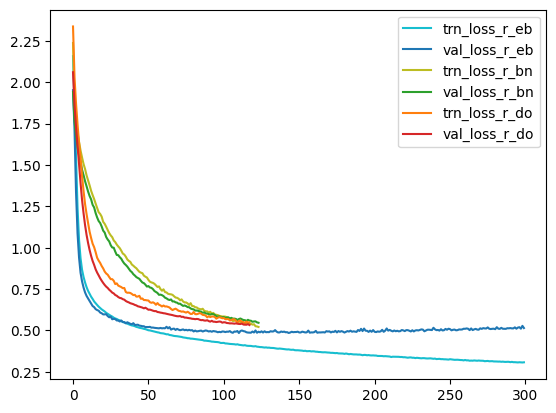

In [12]:
plt.plot(x, [e[0] for e in r_EB_history], "tab:cyan", label="trn_loss_r_eb")
plt.plot(x, [e[2] for e in r_EB_history], "tab:blue", label="val_loss_r_eb")
plt.plot(x3, [e[0] for e in r_BN_history], "tab:olive", label="trn_loss_r_bn")
plt.plot(x3, [e[2] for e in r_BN_history], "tab:green", label="val_loss_r_bn")
plt.plot(x4, [e[0] for e in r_DO_history], "tab:orange", label="trn_loss_r_do")
plt.plot(x4, [e[2] for e in r_DO_history], "tab:red", label="val_loss_r_do")
plt.legend(loc="upper right")
plt.show()


### accuracy

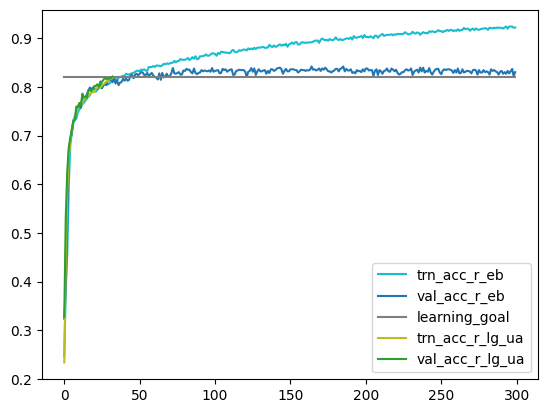

In [13]:
plt.plot(x, [e[1] for e in r_EB_history], "tab:cyan", label="trn_acc_r_eb")
plt.plot(x, [e[3] for e in r_EB_history], "tab:blue", label="val_acc_r_eb")
plt.plot(x, [lg for _ in x], "tab:gray", label="learning_goal")
plt.plot(x1, [e[1] for e in r_LG_UA_history], "tab:olive", label="trn_acc_r_lg_ua")
plt.plot(x1, [e[3] for e in r_LG_UA_history], "tab:green", label="val_acc_r_lg_ua")
# plt.plot(x2, [e[0] for e in r_EB_LG_UA_history], "tab:orange", label="trn_acc_r_eb_lg_ua")
# plt.plot(x2, [e[2] for e in r_EB_LG_UA_history], "tab:red", label="val_acc_r_eb_lg_ua")
plt.legend(loc="lower right")
plt.show()


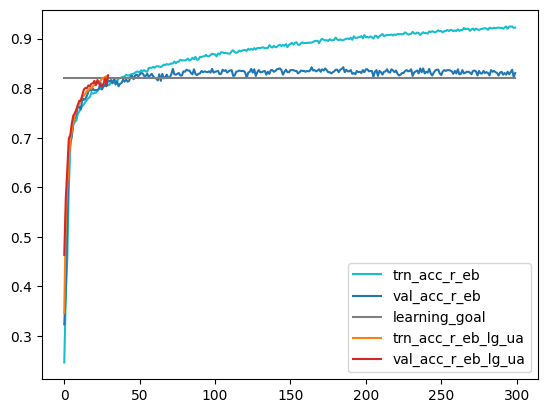

In [14]:
plt.plot(x, [e[1] for e in r_EB_history], "tab:cyan", label="trn_acc_r_eb")
plt.plot(x, [e[3] for e in r_EB_history], "tab:blue", label="val_acc_r_eb")
plt.plot(x, [lg for _ in x], "tab:gray", label="learning_goal")
plt.plot(x2, [e[1] for e in r_EB_LG_UA_history], "tab:orange", label="trn_acc_r_eb_lg_ua")
plt.plot(x2, [e[3] for e in r_EB_LG_UA_history], "tab:red", label="val_acc_r_eb_lg_ua")
plt.legend(loc="lower right")
plt.show()


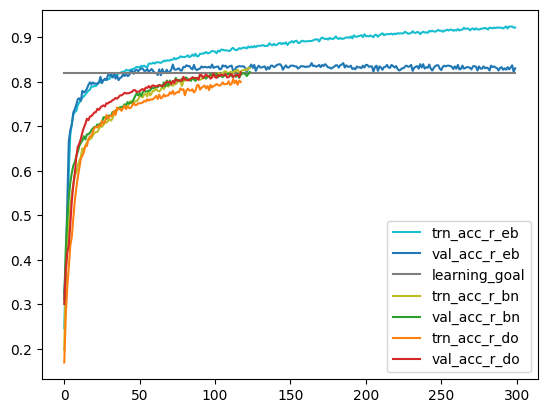

In [16]:
plt.plot(x, [e[1] for e in r_EB_history], "tab:cyan", label="trn_acc_r_eb")
plt.plot(x, [e[3] for e in r_EB_history], "tab:blue", label="val_acc_r_eb")
plt.plot(x, [lg for _ in x], "tab:gray", label="learning_goal")
plt.plot(x3, [e[1] for e in r_BN_history], "tab:olive", label="trn_acc_r_bn")
plt.plot(x3, [e[3] for e in r_BN_history], "tab:green", label="val_acc_r_bn")
plt.plot(x4, [e[1] for e in r_DO_history], "tab:orange", label="trn_acc_r_do")
plt.plot(x4, [e[3] for e in r_DO_history], "tab:red", label="val_acc_r_do")
plt.legend(loc="lower right")
plt.show()
